<a href="https://colab.research.google.com/github/Abdou-ch-d/Breast-Cancer-Detection/blob/main/Detection_Patches.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


#**Pakages**

In [ ]:
%%capture
!pip install -U albumentations

In [ ]:
%%capture
!pip install pydicom

In [ ]:
%%capture
!pip install --force-reinstall albumentations==1.0.3

In [ ]:
%%capture
!pip install SimpleITK

In [ ]:
%%capture
!pip install --force-reinstall opencv-python-headless==4.1.2.30

In [ ]:
%%capture
!pip install git+https://github.com/mjkvaak/ImageDataAugmentor

In [ ]:
%%capture
!pip install split-folders

In [ ]:
%%capture
!pip install import_ipynb

In [ ]:
%%capture
!pip install patchify

In [ ]:
%%capture
!pip install --upgrade --force-reinstall opencv-python-headless==4.1.2.30

In [ ]:
exit()

#Data zip

In [ ]:
!rm -r '/content/Datasets'
# !rm -r '/content/Data'

rm: cannot remove '/content/Datasets': No such file or directory


In [ ]:
%%capture
                              ## Original INBreast
!unzip '/content/drive/MyDrive/INBreast_Dataset/INbreast Release 1.0.zip' -d '/content/Datasets'

# Bib

In [ ]:
import os
!pwd
os.chdir('/content/drive/MyDrive/Colab Notebooks')
!pwd    

/content
/content/drive/MyDrive/Colab Notebooks


In [ ]:
import tensorflow as tf
import numpy as np
import time
import os
import cv2
import random 
import colorsys
from matplotlib.colors import LinearSegmentedColormap
import glob
from tqdm.notebook import tqdm, trange
import albumentations as A

In [ ]:
from keras.models import Model,Sequential,load_model
from keras.layers import Conv2D, Add, ZeroPadding2D, UpSampling2D, Concatenate, MaxPooling2D,Activation,Dropout,Flatten,Conv2D,MaxPooling2D,Dense,Input, Lambda,Input
from keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.python.keras import regularizers 
from tensorflow.keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from tensorflow.keras.utils import Sequence
from keras import backend as K
from patchify import patchify
from functools import reduce
from keras.models import Model
import pydicom as dicom
from PIL import Image 
import matplotlib.pyplot as plt 
from matplotlib.colors import rgb_to_hsv, hsv_to_rgb
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from functools import reduce

In [ ]:
from kerasYolov3  import  box_iou,preprocess_true_boxes,yolo_eval,control_flow_ops
# from Kerasyolo import yolo_loss* 

In [ ]:
os.chdir('/content')
source_path_file = '/content/drive/MyDrive/Colab Notebooks/pre_train.ipynb'
source_path_file = source_path_file.replace(' ', '\\ ')
!cp $source_path_file '/content' # to copy the file from drive to colab
# run this line to sync with the parent file in case you made any changes
!rsync -aP $source_path_file '/content/pre_train.ipynb'

source_path_file = '/content/drive/MyDrive/Colab Notebooks/Dicom_Preprocessing.ipynb'
source_path_file = source_path_file.replace(' ', '\\ ')
!cp $source_path_file '/content' # to copy the file from drive to colab
# run this line to sync with the parent file in case you made any changes
!rsync -aP $source_path_file '/content/Dicom_Preprocessing.ipynb'


import import_ipynb
from pre_train import PreProcessing, Pad_mask
from Dicom_Preprocessing import PreprocessDicomPatches,mask_to_yolo

sending incremental file list
pre_train.ipynb
        556,578 100%  249.77MB/s    0:00:00 (xfr#1, to-chk=0/1)
sending incremental file list
Dicom_Preprocessing.ipynb
         39,980 100%    6.88MB/s    0:00:00 (xfr#1, to-chk=0/1)
importing Jupyter notebook from pre_train.ipynb
importing Jupyter notebook from Dicom_Preprocessing.ipynb


# Model builder
residual skip connections, and upsampling

##Body Layers 

Darknet + ResNet as the base model: The new Darknet-53 still relies on successive 3x3 and 1x1 conv layers, just like the original dark net architecture, but has residual blocks added.

Compose arbitrarily many functions, evaluated left to right.

In [ ]:
def compose(*funcs):
    if funcs:
        return reduce(lambda f, g: lambda *a, **kw: g(f(*a, **kw)), funcs)
    else:
        raise ValueError('Composition of empty sequence not supported.')

Wrapper to set Darknet parameters for Convolution2D

In [ ]:
def DarknetConv2D(*args, **kwargs):
    darknet_conv_kwargs = {'kernel_regularizer': regularizers.l2(5e-4)}#l2(5e-4)}
    darknet_conv_kwargs['padding'] = 'valid' if kwargs.get('strides')==(2,2) else 'same'
    darknet_conv_kwargs.update(kwargs)
    return Conv2D(*args, **darknet_conv_kwargs)

In [ ]:
def DarknetConv2D_BN_Leaky(*args, **kwargs):
    no_bias_kwargs = {'use_bias': False}
    no_bias_kwargs.update(kwargs)
    return compose(
        DarknetConv2D(*args, **no_bias_kwargs),
        BatchNormalization(),
        LeakyReLU(alpha=0.1))

A series of resblocks starting with a downsampling Convolution2D

Darknet uses left and top padding instead of 'same' mode

In [ ]:
def resblock_body(x, num_filters, num_blocks):
    x = ZeroPadding2D(((1,0),(1,0)))(x)
    x = DarknetConv2D_BN_Leaky(num_filters, (3,3), strides=(2,2))(x)
    for i in range(num_blocks):
        y = compose(
                DarknetConv2D_BN_Leaky(num_filters//2, (1,1)),
                DarknetConv2D_BN_Leaky(num_filters, (3,3)))(x)
        x = Add()([x,y])
    return x

Darknent body having 52 Convolution2D layers

In [ ]:
def darknet_body(x):
    x = DarknetConv2D_BN_Leaky(32, (3,3))(x)
    x = resblock_body(x, 64, 1)
    x = resblock_body(x, 128, 2)
    x = resblock_body(x, 256, 8)
    x = resblock_body(x, 512, 8)
    x = resblock_body(x, 1024, 4)
    return x

6 Conv2D_BN_Leaky layers followed by a Conv2D_linear layer

In [ ]:
def make_last_layers(x, num_filters, out_filters):
    x = compose(
            DarknetConv2D_BN_Leaky(num_filters, (1,1)),
            DarknetConv2D_BN_Leaky(num_filters*2, (3,3)),
            DarknetConv2D_BN_Leaky(num_filters, (1,1)),
            DarknetConv2D_BN_Leaky(num_filters*2, (3,3)),
            DarknetConv2D_BN_Leaky(num_filters, (1,1)))(x)
    y = compose(
            DarknetConv2D_BN_Leaky(num_filters*2, (3,3)),
            DarknetConv2D(out_filters, (1,1)))(x)
    return x, y

**Create YOLO_V3 model CNN body in Keras**

In [ ]:
def yolo_body(inputs, num_anchors, num_classes):
    darknet = Model(inputs, darknet_body(inputs))
    x, y1 = make_last_layers(darknet.output, 512, num_anchors*(num_classes+5))

    x = compose(
            DarknetConv2D_BN_Leaky(256, (1,1)),
            UpSampling2D(2))(x)
    x = Concatenate()([x,darknet.layers[152].output])
    x, y2 = make_last_layers(x, 256, num_anchors*(num_classes+5))

    x = compose(
            DarknetConv2D_BN_Leaky(128, (1,1)),
            UpSampling2D(2))(x)
    x = Concatenate()([x,darknet.layers[92].output])
    x, y3 = make_last_layers(x, 128, num_anchors*(num_classes+5))

    return Model(inputs, [y1,y2,y3])

**MobileNet_featur extractor**

In [ ]:
from keras.applications.mobilenet import MobileNet
def yolo_body_MobileNet(inputs, num_anchors, num_classes):
    mobilenet = MobileNet(input_tensor=inputs,weights='imagenet')

    f1 = mobilenet.get_layer('conv_pw_13_relu').output
    # f1 :13 x 13 x 1024
    x, y1 = make_last_layers(f1, 512, num_anchors * (num_classes + 5))
    x = compose(
            DarknetConv2D_BN_Leaky(256, (1,1)),
            UpSampling2D(2))(x)

    f2 = mobilenet.get_layer('conv_pw_11_relu').output
    # f2: 26 x 26 x 512
    x = Concatenate()([x,f2])

    x, y2 = make_last_layers(x, 256, num_anchors*(num_classes+5))
    x = compose(
            DarknetConv2D_BN_Leaky(128, (1,1)),
            UpSampling2D(2))(x)

    f3 = mobilenet.get_layer('conv_pw_5_relu').output
    # f3 : 52 x 52 x 256
    x = Concatenate()([x, f3])
    x, y3 = make_last_layers(x, 128, num_anchors*(num_classes+5))

    return Model(inputs = inputs, outputs=[y1,y2,y3])

**Convert final layer features to bounding box parameters**

In [ ]:
def yolo_head(feats, anchors, num_classes, input_shape, calc_loss=False):
    num_anchors = len(anchors)
    # Reshape to batch, height, width, num_anchors, box_params.
    anchors_tensor = K.reshape(K.constant(anchors), [1, 1, 1, num_anchors, 2])

    grid_shape = K.shape(feats)[1:3] # height, width
    grid_y = K.tile(K.reshape(K.arange(0, stop=grid_shape[0]), [-1, 1, 1, 1]),
        [1, grid_shape[1], 1, 1])
    grid_x = K.tile(K.reshape(K.arange(0, stop=grid_shape[1]), [1, -1, 1, 1]),
        [grid_shape[0], 1, 1, 1])
    grid = K.concatenate([grid_x, grid_y])
    grid = K.cast(grid, K.dtype(feats))

    feats = K.reshape(
        feats, [-1, grid_shape[0], grid_shape[1], num_anchors, num_classes + 5])

    # Adjust preditions to each spatial grid point and anchor size.
    box_xy = (K.sigmoid(feats[..., :2]) + grid) / K.cast(grid_shape[::-1], K.dtype(feats))
    box_wh = K.exp(feats[..., 2:4]) * anchors_tensor / K.cast(input_shape[::-1], K.dtype(feats))
    box_confidence = K.sigmoid(feats[..., 4:5])
    box_class_probs = K.sigmoid(feats[..., 5:])

    if calc_loss == True:
        return grid, feats, box_xy, box_wh
    return box_xy, box_wh, box_confidence, box_class_probs

##**Yolo loss**

 Example: Imagine you have three classes with **label_smoothing** factor as 0.3.

 Then, new_labels according to the above formula will be:

 = [0 1 2] * (1– 0.3) + ( 0.3 / 3 )

 = [0 1 2] * (0.7 )+ 0.1 = [ 0.1 0.8 1.5 ]
 Now, the new labels will be [0.1 0.8 1.5] instead of [0 1 2]

In [ ]:
from re import T
import math
import tensorflow as tf
from tensorflow.keras import backend as K 

def yolo3_decode(feats, anchors, num_classes, input_shape, scale_x_y=None, calc_loss=False):
   
    num_anchors = len(anchors)
    # Reshape to batch, height, width, num_anchors, box_params.
    anchors_tensor = K.reshape(K.constant(anchors), [1, 1, 1, num_anchors, 2])

    grid_shape = K.shape(feats)[1:3] # height, width
    grid_y = K.tile(K.reshape(K.arange(0, stop=grid_shape[0]), [-1, 1, 1, 1]),
        [1, grid_shape[1], 1, 1])
    grid_x = K.tile(K.reshape(K.arange(0, stop=grid_shape[1]), [1, -1, 1, 1]),
        [grid_shape[0], 1, 1, 1])
    grid = K.concatenate([grid_x, grid_y])
    grid = K.cast(grid, K.dtype(feats))

    feats = K.reshape(
        feats, [-1, grid_shape[0], grid_shape[1], num_anchors, num_classes + 5])

    # Adjust preditions to each spatial grid point and anchor size.
    if scale_x_y:
        box_xy_tmp = K.sigmoid(feats[..., :2]) * scale_x_y - (scale_x_y - 1) / 2
        box_xy = (box_xy_tmp + grid) / K.cast(grid_shape[..., ::-1], K.dtype(feats))
    else:
        box_xy = (K.sigmoid(feats[..., :2]) + grid) / K.cast(grid_shape[..., ::-1], K.dtype(feats))
    box_wh = K.exp(feats[..., 2:4]) * anchors_tensor / K.cast(input_shape[..., ::-1], K.dtype(feats))
    box_confidence = K.sigmoid(feats[..., 4:5])
    box_class_probs = K.sigmoid(feats[..., 5:])

    if calc_loss == True:
        return grid, feats, box_xy, box_wh
    return box_xy, box_wh, box_confidence, box_class_probs



def softmax_focal_loss(y_true, y_pred, gamma=2.5, alpha=0.25):    #gamma=2
    #  alpha:  Weighting factor in range (0,1) to balance positive vs negative examples or -1 for ignore. 
    #  gamma: Exponent of the modulating factor (1 - p_t) to balance easy vs hard examples.
    y_pred = tf.nn.softmax(y_pred)
    y_pred = tf.maximum(tf.minimum(y_pred, 1 - 1e-15), 1e-15)
   
    # Calculate Cross Entropy
    cross_entropy = -y_true * tf.math.log(y_pred)
   
    # Calculate Focal Loss
    softmax_focal_loss = alpha * tf.pow(1 - y_pred, gamma) * cross_entropy

    return softmax_focal_loss


def sigmoid_focal_loss(y_true, y_pred, gamma=2.5, alpha=0.25):
  #  alpha:  Weighting factor in range (0,1) to balance positive vs negative examples or -1 for ignore. 
  #  gamma: Exponent of the modulating factor (1 - p_t) to balance easy vs hard examples.
  
    sigmoid_loss = K.binary_crossentropy(y_true, y_pred, from_logits=True)

    pred_prob = tf.sigmoid(y_pred)
    p_t = ((y_true * pred_prob) + ((1 - y_true) * (1 - pred_prob)))
    modulating_factor = tf.pow(1.0 - p_t, gamma)
    alpha_weight_factor = (y_true * alpha + (1 - y_true) * (1 - alpha))

    sigmoid_focal_loss = modulating_factor * alpha_weight_factor * sigmoid_loss
    sigmoid_focal_loss = tf.reduce_sum(sigmoid_focal_loss, axis=-1)

    return sigmoid_focal_loss



def box_iou(b1, b2):
   
    # Expand dim to apply broadcasting.
    b1 = K.expand_dims(b1, -2)
    b1_xy = b1[..., :2]
    b1_wh = b1[..., 2:4]
    b1_wh_half = b1_wh/2.
    b1_mins = b1_xy - b1_wh_half
    b1_maxes = b1_xy + b1_wh_half

    # Expand dim to apply broadcasting.
    b2 = K.expand_dims(b2, 0)
    b2_xy = b2[..., :2]
    b2_wh = b2[..., 2:4]
    b2_wh_half = b2_wh/2.
    b2_mins = b2_xy - b2_wh_half
    b2_maxes = b2_xy + b2_wh_half

    intersect_mins = K.maximum(b1_mins, b2_mins)
    intersect_maxes = K.minimum(b1_maxes, b2_maxes)
    intersect_wh = K.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_area = intersect_wh[..., 0] * intersect_wh[..., 1]
    b1_area = b1_wh[..., 0] * b1_wh[..., 1]
    b2_area = b2_wh[..., 0] * b2_wh[..., 1]
    iou = intersect_area / (b1_area + b2_area - intersect_area)

    return iou


def box_giou(b_true, b_pred):
    """
        "Generalized Iou: A Metric and A Loss for Bounding Box Regression"
    """
    b_true_xy = b_true[..., :2]
    b_true_wh = b_true[..., 2:4]
    b_true_wh_half = b_true_wh/2.
    b_true_mins = b_true_xy - b_true_wh_half
    b_true_maxes = b_true_xy + b_true_wh_half

    b_pred_xy = b_pred[..., :2]
    b_pred_wh = b_pred[..., 2:4]
    b_pred_wh_half = b_pred_wh/2.
    b_pred_mins = b_pred_xy - b_pred_wh_half
    b_pred_maxes = b_pred_xy + b_pred_wh_half

    intersect_mins = K.maximum(b_true_mins, b_pred_mins)
    intersect_maxes = K.minimum(b_true_maxes, b_pred_maxes)
    intersect_wh = K.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_area = intersect_wh[..., 0] * intersect_wh[..., 1]
    b_true_area = b_true_wh[..., 0] * b_true_wh[..., 1]
    b_pred_area = b_pred_wh[..., 0] * b_pred_wh[..., 1]
    union_area = b_true_area + b_pred_area - intersect_area
    # calculate IoU, add epsilon in denominator to avoid dividing by 0
    iou = intersect_area / (union_area + K.epsilon())

    # get enclosed area
    enclose_mins = K.minimum(b_true_mins, b_pred_mins)
    enclose_maxes = K.maximum(b_true_maxes, b_pred_maxes)
    enclose_wh = K.maximum(enclose_maxes - enclose_mins, 0.0)
    enclose_area = enclose_wh[..., 0] * enclose_wh[..., 1]
    # calculate GIoU, add epsilon in denominator to avoid dividing by 0
    giou = iou - 1.0 * (enclose_area - union_area) / (enclose_area + K.epsilon())
    giou = K.expand_dims(giou, -1)

    return giou


def box_diou(b_true, b_pred, use_ciou=False):
    """
        "Distance-IoU Loss: Faster and Better Learning for Bounding Box Regression"
    """
    b_true_xy = b_true[..., :2]
    b_true_wh = b_true[..., 2:4]
    b_true_wh_half = b_true_wh/2.
    b_true_mins = b_true_xy - b_true_wh_half
    b_true_maxes = b_true_xy + b_true_wh_half

    b_pred_xy = b_pred[..., :2]
    b_pred_wh = b_pred[..., 2:4]
    b_pred_wh_half = b_pred_wh/2.
    b_pred_mins = b_pred_xy - b_pred_wh_half
    b_pred_maxes = b_pred_xy + b_pred_wh_half

    intersect_mins = K.maximum(b_true_mins, b_pred_mins)
    intersect_maxes = K.minimum(b_true_maxes, b_pred_maxes)
    intersect_wh = K.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_area = intersect_wh[..., 0] * intersect_wh[..., 1]
    b_true_area = b_true_wh[..., 0] * b_true_wh[..., 1]
    b_pred_area = b_pred_wh[..., 0] * b_pred_wh[..., 1]
    union_area = b_true_area + b_pred_area - intersect_area
    # calculate IoU, add epsilon in denominator to avoid dividing by 0
    iou = intersect_area / (union_area + K.epsilon())

    # box center distance
    center_distance = K.sum(K.square(b_true_xy - b_pred_xy), axis=-1)
    # get enclosed area
    enclose_mins = K.minimum(b_true_mins, b_pred_mins)
    enclose_maxes = K.maximum(b_true_maxes, b_pred_maxes)
    enclose_wh = K.maximum(enclose_maxes - enclose_mins, 0.0)
    # get enclosed diagonal distance
    enclose_diagonal = K.sum(K.square(enclose_wh), axis=-1)
    # calculate DIoU, add epsilon in denominator to avoid dividing by 0
    diou = iou - 1.0 * (center_distance) / (enclose_diagonal + K.epsilon())

    if use_ciou:
        # calculate param v and alpha to extend to CIoU
        v = 4*K.square(tf.math.atan2(b_true_wh[..., 0], b_true_wh[..., 1]) - tf.math.atan2(b_pred_wh[..., 0], b_pred_wh[..., 1])) / (math.pi * math.pi)
        v = v * tf.stop_gradient(b_pred_wh[..., 0] * b_pred_wh[..., 0] + b_pred_wh[..., 1] * b_pred_wh[..., 1])

        alpha = v / (1.0 - iou + v)
        diou = diou - alpha*v

    diou = K.expand_dims(diou, -1)
    return diou


def _smooth_labels(y_true, label_smoothing):
    label_smoothing = K.constant(label_smoothing, dtype=K.floatx())
    return y_true * (1.0 - label_smoothing) + 0.5 * label_smoothing


def yolo3_loss(args, anchors, num_classes, ignore_thresh=.5, label_smoothing= 0, elim_grid_sense=False, use_focal_loss=False, use_softmax_loss=True, use_focal_obj_loss=False,  use_giou_loss=False, use_diou_loss=True ):
    '''
    YOLOv3 loss function.
    Parameters
    ----------
    yolo_outputs: list of tensor, the output of yolo_body
    y_true: list of array, the output of preprocess_true_boxes
    anchors: array, shape=(N, 2), wh
    num_classes: integer
    ignore_thresh: float, the iou threshold whether to ignore object confidence loss
    Returns
    -------
    loss: tensor, shape=(1,)
    '''
    num_layers = len(anchors)//3 # default setting
    yolo_outputs = args[:num_layers]
    y_true = args[num_layers:]

    if num_layers == 3:
        anchor_mask = [[6,7,8], [3,4,5], [0,1,2]]
        scale_x_y = [1.05, 1.1, 1.2] if elim_grid_sense else [None, None, None]
    else:
        anchor_mask = [[3,4,5], [0,1,2]]
        scale_x_y = [1.05, 1.05] if elim_grid_sense else [None, None]

    input_shape = K.cast(K.shape(yolo_outputs[0])[1:3] * 32, K.dtype(y_true[0]))
    grid_shapes = [K.cast(K.shape(yolo_outputs[i])[1:3], K.dtype(y_true[0])) for i in range(num_layers)]
    loss = 0
    total_location_loss = 0
    total_confidence_loss = 0
    total_class_loss = 0
    batch_size = K.shape(yolo_outputs[0])[0] # batch size, tensor
    batch_size_f = K.cast(batch_size, K.dtype(yolo_outputs[0]))

    for i in range(num_layers):
        object_mask = y_true[i][..., 4:5]
        true_class_probs = y_true[i][..., 5:]
        if label_smoothing:

            true_class_probs = _smooth_labels(true_class_probs, label_smoothing)
            true_objectness_probs = _smooth_labels(object_mask, label_smoothing)
        else:
            true_objectness_probs = object_mask

        grid, raw_pred, pred_xy, pred_wh = yolo3_decode(yolo_outputs[i],
             anchors[anchor_mask[i]], num_classes, input_shape, scale_x_y=scale_x_y[i], calc_loss=True)
        pred_box = K.concatenate([pred_xy, pred_wh])

        # Darknet raw box to calculate loss.
        raw_true_xy = y_true[i][..., :2]*grid_shapes[i][::-1] - grid
        raw_true_wh = K.log(y_true[i][..., 2:4] / anchors[anchor_mask[i]] * input_shape[::-1])
        raw_true_wh = K.switch(object_mask, raw_true_wh, K.zeros_like(raw_true_wh)) # avoid log(0)=-inf
        box_loss_scale = 2 - y_true[i][...,2:3]*y_true[i][...,3:4]

        # Find ignore mask, iterate over each of batch.
        ignore_mask = tf.TensorArray(K.dtype(y_true[0]), size=1, dynamic_size=True)
        object_mask_bool = K.cast(object_mask, 'bool')
        def loop_body(b, ignore_mask):
            true_box = tf.boolean_mask(y_true[i][b,...,0:4], object_mask_bool[b,...,0])
            iou = box_iou(pred_box[b], true_box)
            best_iou = K.max(iou, axis=-1)
            ignore_mask = ignore_mask.write(b, K.cast(best_iou<ignore_thresh, K.dtype(true_box)))
            return b+1, ignore_mask
        _, ignore_mask = tf.while_loop(lambda b,*args: b<batch_size, loop_body, [0, ignore_mask])
        ignore_mask = ignore_mask.stack()
        ignore_mask = K.expand_dims(ignore_mask, -1)

        if use_focal_obj_loss:
            # Focal loss for objectness confidence
            confidence_loss = sigmoid_focal_loss(true_objectness_probs, raw_pred[...,4:5])
        else:    
            confidence_loss = object_mask * K.binary_crossentropy(true_objectness_probs, raw_pred[...,4:5], from_logits=True)+ \
                (1-object_mask) * K.binary_crossentropy(object_mask, raw_pred[...,4:5], from_logits=True) * ignore_mask
                
        if use_focal_loss:
            # Focal loss for classification score
            if use_softmax_loss:
                class_loss = softmax_focal_loss(true_class_probs, raw_pred[...,5:])
            else:
                class_loss = sigmoid_focal_loss(true_class_probs, raw_pred[...,5:])
        else:
            if use_softmax_loss:
                # use softmax style classification output
                class_loss = object_mask * K.expand_dims(K.categorical_crossentropy(true_class_probs, raw_pred[...,5:], from_logits=True), axis=-1)
            else:
                # use sigmoid style classification output
                class_loss = object_mask * K.binary_crossentropy(true_class_probs, raw_pred[...,5:], from_logits=True)


        if use_giou_loss:
            # Calculate GIoU 'Generalized Intersection...' loss as location loss
            raw_true_box = y_true[i][...,0:4]
            giou = box_giou(raw_true_box, pred_box)
            giou_loss = object_mask * box_loss_scale * (1 - giou)
            giou_loss = K.sum(giou_loss) / batch_size_f
            location_loss = giou_loss
        elif use_diou_loss:
            # Calculate DIoU 'Distance'loss as location loss
            raw_true_box = y_true[i][...,0:4]
            diou = box_diou(raw_true_box, pred_box)
            diou_loss = object_mask * box_loss_scale * (1 - diou)
            diou_loss = K.sum(diou_loss) / batch_size_f
            location_loss = diou_loss
        else:
            # Standard YOLOv3 location loss
            # K.binary_crossentropy is helpful to avoid exp overflow.
            xy_loss = object_mask * box_loss_scale * K.binary_crossentropy(raw_true_xy, raw_pred[...,0:2], from_logits=True)
            wh_loss = object_mask * box_loss_scale * 0.5 * K.square(raw_true_wh-raw_pred[...,2:4])
            xy_loss = K.sum(xy_loss) / batch_size_f
            wh_loss = K.sum(wh_loss) / batch_size_f
            location_loss = xy_loss + wh_loss

        # only involve class loss for multiple classes
        if num_classes == 1:
            class_loss = K.constant(0)
        else:
            class_loss = K.sum(class_loss) / batch_size_f

        confidence_loss = K.sum(confidence_loss) / batch_size_f
        loss += location_loss + confidence_loss + class_loss
        total_location_loss += location_loss
        total_confidence_loss += confidence_loss
        total_class_loss += class_loss

    # Fit for tf 2.0.0 loss shape
    loss = K.expand_dims(loss, axis=-1)

    return loss #,total_location_loss, total_confidence_loss, total_class_loss

## **Create the training model**

In [ ]:
def create_model(input_shape,anchors,num_classes,backboon='Darknet' ,load_pretrained=True, freeze_body=0,elim_grid_sense=False,
                 weights_path='/content/drive/MyDrive/Detection_models/pré-trined/yolov4.h5',label_smoothing=0):
  
    K.clear_session() # get a new session
    image_input = Input(shape=(None, None, 3))
    h, w = input_shape
    num_anchors = len(anchors)

    y_true = [Input(shape=(h//{0:32, 1:16, 2:8}[l], w//{0:32, 1:16, 2:8}[l], \
        num_anchors//3, num_classes+5)) for l in range(3)]

    if(backboon=='Darknet'):
      model_body = yolo_body(image_input, num_anchors//3, num_classes)
      print('yolo based Darknet')
    elif(backboon=='MobileNet'):
      model_body=yolo_body_MobileNet(image_input, num_anchors//3, num_classes)
      print('yolo based MobileNet')

    print('Create YOLOv3 model based on {} with {} anchors and {} classes.'.format(backboon,num_anchors, num_classes))

    if load_pretrained:
        model_body.load_weights(weights_path, by_name=True, skip_mismatch=True)
        print('Load weights {}.'.format(weights_path))
        # if freeze_body in [1, 2]:
        #     # Freeze darknet53 body or freeze all but 3 output layers.
        #     num = (185, len(model_body.layers)-3)[freeze_body-1]
        #     for i in range(num): model_body.layers[i].trainable = False
        #     print('Freeze the first {} layers of total {} layers.'.format(num, len(model_body.layers)))


    # model_loss = Lambda(yolo_loss, output_shape=(1,), name='yolo_loss',
    #     arguments={'anchors': anchors, 'num_classes': num_classes, 'ignore_thresh': 0.5})(
    #     [*model_body.output, *y_true])
    # model = Model([model_body.input, *y_true], model_loss)
    #-------------
    #, location_loss, confidence_loss, class_loss
    model_loss = Lambda(yolo3_loss, name='yolo_loss',
            arguments={'anchors': anchors, 'num_classes': num_classes, 'ignore_thresh': 0.5, 'label_smoothing': label_smoothing, 'elim_grid_sense': elim_grid_sense})(
        [*model_body.output, *y_true])

    model = Model([model_body.input, *y_true], model_loss)

    # loss_dict = {'location_loss':location_loss, 'confidence_loss':confidence_loss, 'class_loss':class_loss}
    # add_metrics(model, loss_dict)
    
    return  model

add metric scalar tensor into model, which could be tracked in training
    log and tensorboard callback

In [ ]:
def add_metrics(model, metric_dict):
    for (name, metric) in metric_dict.items():
        model.add_metric(metric, name=name, aggregation='mean')

**original loss**

In [ ]:
def yolo_loss(args, anchors, num_classes, ignore_thresh=.5, print_loss=False):
    '''Return yolo_loss tensor
    Parameters
    ----------
    yolo_outputs: list of tensor, the output of yolo_body or tiny_yolo_body
    y_true: list of array, the output of preprocess_true_boxes
    anchors: array, shape=(N, 2), wh
    num_classes: integer
    ignore_thresh: float, the iou threshold whether to ignore object confidence loss
    Returns
    -------
    loss: tensor, shape=(1,)
    '''
    num_layers = len(anchors)//3 # default setting
    yolo_outputs = args[:num_layers]
    y_true = args[num_layers:]
    anchor_mask = [[6,7,8], [3,4,5], [0,1,2]] if num_layers==3 else [[3,4,5], [1,2,3]]
    input_shape = K.cast(K.shape(yolo_outputs[0])[1:3] * 32, K.dtype(y_true[0]))
    grid_shapes = [K.cast(K.shape(yolo_outputs[l])[1:3], K.dtype(y_true[0])) for l in range(num_layers)]
    loss = 0
    m = K.shape(yolo_outputs[0])[0] # batch size, tensor
    mf = K.cast(m, K.dtype(yolo_outputs[0]))

    for l in range(num_layers):
        object_mask = y_true[l][..., 4:5]
        true_class_probs = y_true[l][..., 5:]

        grid, raw_pred, pred_xy, pred_wh = yolo_head(yolo_outputs[l],
             anchors[anchor_mask[l]], num_classes, input_shape, calc_loss=True)
        pred_box = K.concatenate([pred_xy, pred_wh])

        # Darknet raw box to calculate loss.
        raw_true_xy = y_true[l][..., :2]*grid_shapes[l][::-1] - grid
        raw_true_wh = K.log(y_true[l][..., 2:4] / anchors[anchor_mask[l]] * input_shape[::-1])
        raw_true_wh = K.switch(object_mask, raw_true_wh, K.zeros_like(raw_true_wh)) # avoid log(0)=-inf
        box_loss_scale = 2 - y_true[l][...,2:3]*y_true[l][...,3:4]

        # Find ignore mask, iterate over each of batch.
        ignore_mask = tf.TensorArray(K.dtype(y_true[0]), size=1, dynamic_size=True)
        object_mask_bool = K.cast(object_mask, 'bool')
        def loop_body(b, ignore_mask):
            true_box = tf.boolean_mask(y_true[l][b,...,0:4], object_mask_bool[b,...,0])
            iou = box_iou(pred_box[b], true_box)
            best_iou = K.max(iou, axis=-1)
            ignore_mask = ignore_mask.write(b, K.cast(best_iou<ignore_thresh, K.dtype(true_box)))
            return b+1, ignore_mask
        _, ignore_mask =tf.while_loop(lambda b,*args: b<m, loop_body, [0, ignore_mask])   #K.control_flow_ops.while_loop  
        ignore_mask = ignore_mask.stack()
        ignore_mask = K.expand_dims(ignore_mask, -1)

        # K.binary_crossentropy is helpful to avoid exp overflow.
        xy_loss = object_mask * box_loss_scale * K.binary_crossentropy(raw_true_xy, raw_pred[...,0:2], from_logits=True)
        wh_loss = object_mask * box_loss_scale * 0.5 * K.square(raw_true_wh-raw_pred[...,2:4])
        confidence_loss = object_mask * K.binary_crossentropy(object_mask, raw_pred[...,4:5], from_logits=True)+ \
            (1-object_mask) * K.binary_crossentropy(object_mask, raw_pred[...,4:5], from_logits=True) * ignore_mask
        class_loss = object_mask * K.binary_crossentropy(true_class_probs, raw_pred[...,5:], from_logits=True)

        xy_loss = K.sum(xy_loss) / mf
        wh_loss = K.sum(wh_loss) / mf
        confidence_loss = K.sum(confidence_loss) / mf
        class_loss = K.sum(class_loss) / mf
        print("xy_loss",xy_loss,"\nwh_loss",wh_loss,"\nconfidence_loss",confidence_loss,"\nclass_loss",class_loss)
        loss += xy_loss + wh_loss + confidence_loss + class_loss
        if print_loss:
            loss = tf.Print(loss, [loss, xy_loss, wh_loss, confidence_loss, class_loss, K.sum(ignore_mask)], message='loss: ')
    return loss

#New preprossesing & augmentations

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.random import set_seed

In [ ]:
input_folder= '/content/Datasets/INbreast Release 1.0/'

seed=60
batch_size=16
size=256

np.random.seed(seed)
set_seed(seed)
random.seed(seed)

In [ ]:
import glob
XMLS=input_folder+'AllXML/*.xml'
xml=glob.glob(XMLS)
Callcification_PATIENT_ID=[x.split('/')[-1].split('.')[0]for x in xml]

# Split the data into train val & test set
train_set,test_set  = train_test_split(Callcification_PATIENT_ID, test_size = 0.1, random_state=seed)
# train_set, test_set = train_test_split(train_set, test_size = 0.11, random_state=seed)

print("train set: {0}\ntest set: {1}".format(len(train_set),
                                    # len(val_set),
                                    len(test_set)
                                    )
      )

train set: 308
test set: 35


In [ ]:
gen_dataset_path='Train_Set/'
!rm -r {gen_dataset_path}
!mkdir {gen_dataset_path}
!mkdir {gen_dataset_path+'Images/'}
!mkdir {gen_dataset_path+'Masks_masses/'}
!mkdir {gen_dataset_path+'Masks_cal/'}

In [ ]:
PreprocessDicomPatches(train_set, 256, 1, input_folder, gen_dataset_path)

  0%|          | 0/308 [00:00<?, ?it/s]

In [ ]:
fargh=0
for p in tqdm(glob.glob(gen_dataset_path+'Masks_masses/*')):
  if len(np.unique(dicom.dcmread(p).pixel_array))-1==0:
    fargh=fargh+1
fargh

  0%|          | 0/34858 [00:00<?, ?it/s]

33952

In [ ]:
farghs=0
for p in tqdm(glob.glob(gen_dataset_path+'Masks_cal/*')):
  if len(np.unique(dicom.dcmread(p).pixel_array))-1==0:
    farghs=farghs+1
farghs

  0%|          | 0/34665 [00:00<?, ?it/s]

30776

In [ ]:
cpt=0
IDs=[]
print(len(glob.glob(gen_dataset_path+'Images/*')))
for p in tqdm(glob.glob(gen_dataset_path+'Images/*')):
    if len(np.unique(dicom.dcmread(gen_dataset_path+'Masks_masses/'+p.split("/")[-1]).pixel_array))-1==0 and len(np.unique(dicom.dcmread(gen_dataset_path+'Masks_cal/'+p.split("/")[-1]).pixel_array))-1==0:
      cpt=cpt+1
      IDs.append(p)
print(cpt)
print(len(glob.glob(gen_dataset_path+'Images/*')))


34858


  0%|          | 0/34858 [00:00<?, ?it/s]

30053
34858


In [ ]:
ss=random.choice(IDs)
ss

'Train_Set/Images/35_57.dcm'

In [ ]:
print(len(IDs))
print(len(glob.glob(gen_dataset_path+'Images/*')),len(glob.glob(gen_dataset_path+'Masks_masses/*')),len(glob.glob(gen_dataset_path+'Masks_cal/*')))
# 25248
for i in range(25248):
    pat=random.choice(IDs)
    os.remove(pat)
    os.remove(gen_dataset_path+'Masks_masses/'+pat.split("/")[-1])
    os.remove(gen_dataset_path+'Masks_cal/'+pat.split("/")[-1])   

print(len(IDs))
print(len(glob.glob(gen_dataset_path+'Images/*')),len(glob.glob(gen_dataset_path+'Masks_masses/*')),len(glob.glob(gen_dataset_path+'Masks_cal/*')))

Test data

In [ ]:
gen_dataset_path='Test_Set/'
!rm -r {gen_dataset_path}
!mkdir {gen_dataset_path}
!mkdir {gen_dataset_path+'Images/'}
!mkdir {gen_dataset_path+'Masks_masses/'}
!mkdir {gen_dataset_path+'Masks_cal/'}

In [ ]:
# PreprocessDicomPatches(test_set, 512, 8, input_folder, gen_dataset_path)

In [ ]:
# !zip -r '/content/drive/MyDrive/INBreast_Dataset/Dicom_Test_data.zip' '/content/Test_Set'


nb calc 0 nb masses 0


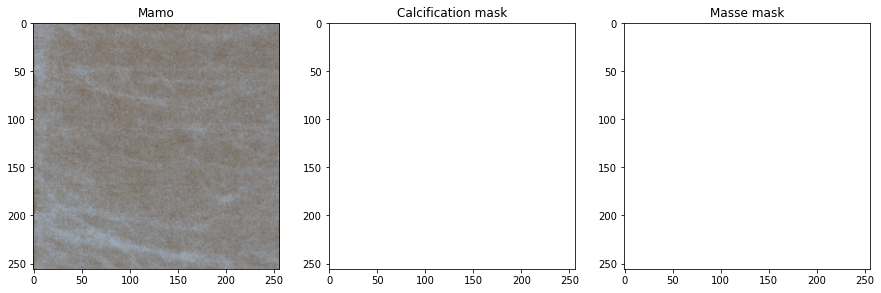

In [ ]:
# r=random.choice(glob.glob('GenDataset/'+'Images/*')).split("/")[-1]
r=random.choice(glob.glob('Train_Set/'+'Images/*')).split("/")[-1]

fig = plt.figure(figsize=(15, 15))

fig.add_subplot(131)
# fig.add_subplot(121)
plt.title("Mamo")
plt.imshow(dicom.dcmread('Train_Set/'+'Images/'+r).pixel_array)

dc_test_mask_cal=dicom.dcmread('Train_Set/'+'Masks_cal/'+r).pixel_array
fig.add_subplot(132)
# fig.add_subplot(122)
plt.title("Calcification mask")
plt.imshow(dc_test_mask_cal, cmap="binary")

dc_test_mask_masse=dicom.dcmread('Train_Set/'+'Masks_masses/'+r).pixel_array

fig.add_subplot(133)
plt.title("Masse mask")
plt.imshow(dc_test_mask_masse, cmap="binary")
print("nb calc", len(np.unique(dc_test_mask_cal))-1,"nb masses", len(np.unique(dc_test_mask_masse))-1)
plt.show()

# **Truth_Data_generators**

**Preprocess true boxes to training input format**
    Parameters
    ----------
    true_boxes: array, shape=(m, T, 5)
        Absolute x_min, y_min, x_max, y_max, class_id relative to input_shape.
    input_shape: array-like, hw, multiples of 32
    anchors: array, shape=(N, 2), wh
    num_classes: integer
    Returns
    -------
    y_true: list of array, shape like yolo_outputs, xywh are reletive value
    

In [ ]:
def preprocess_true_boxes(true_boxes, input_shape, anchors, num_classes):
   
    assert (true_boxes[..., 4]<num_classes).all(), 'class id must be less than num_classes'
    num_layers = len(anchors)//3 # default setting
    anchor_mask = [[6,7,8], [3,4,5], [0,1,2]] if num_layers==3 else [[3,4,5], [1,2,3]]

    true_boxes = np.array(true_boxes, dtype='float32')
    input_shape = np.array(input_shape, dtype='int32')
    boxes_xy = (true_boxes[..., 0:2] + true_boxes[..., 2:4]) // 2
    boxes_wh = true_boxes[..., 2:4] - true_boxes[..., 0:2]
    true_boxes[..., 0:2] = boxes_xy/input_shape[::-1]
    true_boxes[..., 2:4] = boxes_wh/input_shape[::-1]


    m = true_boxes.shape[0]
    grid_shapes = [input_shape//{0:32, 1:16, 2:8}[l] for l in range(num_layers)]
    y_true = [np.zeros((m,grid_shapes[l][0],grid_shapes[l][1],len(anchor_mask[l]),5+num_classes),
        dtype='float32') for l in range(num_layers)]

    # Expand dim to apply broadcasting.
    anchors = np.expand_dims(anchors, 0)
    anchor_maxes = anchors / 2.
    anchor_mins = -anchor_maxes
    valid_mask = boxes_wh[..., 0]>0

    for b in range(m):
        # Discard zero rows.
        wh = boxes_wh[b, valid_mask[b]]
        if len(wh)==0: continue
        # Expand dim to apply broadcasting.
        wh = np.expand_dims(wh, -2)
        box_maxes = wh / 2.
        box_mins = -box_maxes

        intersect_mins = np.maximum(box_mins, anchor_mins)
        intersect_maxes = np.minimum(box_maxes, anchor_maxes)
        intersect_wh = np.maximum(intersect_maxes - intersect_mins, 0.)
        intersect_area = intersect_wh[..., 0] * intersect_wh[..., 1]
        box_area = wh[..., 0] * wh[..., 1]
        anchor_area = anchors[..., 0] * anchors[..., 1]
        iou = intersect_area / (box_area + anchor_area - intersect_area)

        # Find best anchor for each true box
        best_anchor = np.argmax(iou, axis=-1)

        for t, n in enumerate(best_anchor):
            for l in range(num_layers):
                if n in anchor_mask[l]:
                    i = np.floor(true_boxes[b,t,0]*grid_shapes[l][1]).astype('int32')
                    j = np.floor(true_boxes[b,t,1]*grid_shapes[l][0]).astype('int32')
                    k = anchor_mask[l].index(n)
                    c = true_boxes[b,t, 4].astype('int32')
                    y_true[l][b, j, i, k, 0:4] = true_boxes[b,t, 0:4]
                    y_true[l][b, j, i, k, 4] = 1
                    y_true[l][b, j, i, k, 5+c] = 1

    return y_true

In [ ]:
from itertools import count
def data_generator(ens,batch_size, input_shape, anchors, num_classes,size,DatasetPath):
    
    # if(ens==1):
    #   n = 240
    #   Gen=train_generator
    # elif(ens==2): 
    #   n=68
    #   Gen=val_generator
    n=len(ens)
    i = 0
    
    while True:
        image_data = []
        list_box_data = []
        # image,mask=next(Gen)
        
        for b in range(batch_size):
            box = []
            image= dicom.dcmread(DatasetPath+'Images/'+ens[i]).pixel_array/255
            #---------------------
            mask_cal= dicom.dcmread(DatasetPath+'Masks_cal/'+ens[i]).pixel_array
            mask_masse=dicom.dcmread(DatasetPath+'Masks_masses/'+ens[i]).pixel_array

            if size != 1024:
              image= cv2.resize(image, (size, size), interpolation = cv2.INTER_AREA)
              mask_cal= cv2.resize(mask_cal, (size, size), interpolation = cv2.INTER_NEAREST)
              mask_masse=cv2.resize(mask_masse, (size, size), interpolation = cv2.INTER_NEAREST)

            image_data.append(image)
        
            box_cal=mask_to_yolo(mask_cal,0)
            [box.append(bx) for bx in box_cal]
          
            box_masse=mask_to_yolo(mask_masse,1)
            [box.append(bx) for bx in box_masse]
         
            box_data = np.zeros((500,5))
            box=np.array(box)
            
            if (len(box)>0):
              box_data[:len(box)] =box

        
            list_box_data.append(box_data)
            i = (i+1) % n
        
        #-------------------
        list_box_data=np.array(list_box_data)
       
        image_data=np.array(image_data)

     
        y_true = preprocess_true_boxes(list_box_data, input_shape, anchors, num_classes)
        
        yield [image_data, *y_true], np.zeros(batch_size)

In [ ]:
def rand(a=0, b=1):
    return np.random.rand()*(b-a) + a

**extarct classes from txt file**

In [ ]:
def get_classes(classes_path):
    with open(classes_path) as f:
        class_names = f.readlines()
    class_names = [c.strip() for c in class_names]
    return class_names

**loads the anchors from a file**

In [ ]:
def get_anchors(anchors_path):
    with open(anchors_path) as f:
        anchors = f.readline()
    anchors = [float(x) for x in anchors.split(',')]
    return np.array(anchors).reshape(-1, 2)

# **Training process**

In [ ]:
#@title plot_training_statistics{form-width: "1%"}
def plot_training_statistics(history, path):
    epochs = [i for i in range(1, len(history['loss'])+1)]

    plt.figure(figsize=(20,6))
    keys = history.keys()
    keys = [key for key in keys if not "lr" in key and not "val_" in key]
    
    for idx, key in enumerate(keys):
        plt.subplot(1, len(keys), idx+1)
        plt.plot(epochs, history[key], label="training_"+key)
        plt.plot(epochs, history['val_'+key], label="validation_"+key)
        plt.legend(loc='best')
        plt.title(key)
        plt.xlabel('epoch')

    # plt.subplot(1, len(keys)+1,idx+1)
    # plt.title('learning_rate')
    # plt.xlabel('epoch')
    # plt.plot(epochs, history['lr'], label="learning_rate")

    # plt.savefig(f'{path}ploted_stats.png')
    plt.show()
    plt.close('all')

In [ ]:
#@title Anchors{form-width: "1%"}

#0,1,  0,0,  1,0,  2,1,  4,2,  6,3,  11,6,  21,11,  67,38
#anchors of masses and calcification
# anchors=np.array([[  0.62 ,   0.51 ],
#        [  2.24 ,   1.2  ],
#        [  5.09 ,   2.63 ],
#        [  9.91 ,   4.99 ],
#        [ 23.215,  11.155],
#        [ 56.485,  26.665],
#        [106.62 ,  53.665],
#        [180.46 ,  96.915],
#        [287.555, 181.29 ]])

# anchors = get_anchors(anchors_path)
# ANCHORS OF  just Callcifications
# anchors= np.array([[ 1.,   1.],
#  [ 1.51923077,2.38461538],
#  [ 2.45454545 , 1.        ],
#  [ 2.74509804 , 5.17647059],
#  [ 4.42857143 ,10.95238095],
#  [ 4.87301587 , 2.33333333],
#  [ 5.         , 1.        ],
#  [10.68421053 , 4.47368421],
#  [30.65       ,11.7       ]])

anchors=[[300,66,333,279,372,362],[163,272,242,130,299,191],[51,43,78, 218,116,84 ]]
300,66, 333,279, 372,362, 163,272, 242,130, 299,191, 51,43, 78, 218, 116,84
anchors= [[0.01659321,0.00996796],
[0.02322134,0.01339871],
 [0.04895603,0.02613155],
 [0.09038873,0.04803848],
  [0.15177747,0.07992665],
  [0.22864079,0.12244233],
  [0.37213292,0.19061959],
   [0.69372979,0.35726062],
  [2.0586748,1.06487927]]


   [[0.01684334 0.01027266]
 [0.02715052 0.01462808]
 [0.058329   0.03008491]
 [0.1029251  0.05297063]
 [0.16298039 0.08699561]
 [0.24962453 0.13274962]
 [0.38254428 0.21181243]
 [0.72267308 0.38419121]
 [2.13097623 1.20345532]]

 anchors= 10,13,  16,30,  33,23,  30,61,  62,45,  59,119,  116,90,  156,198,  373,326
 12, 16, 19, 36, 40, 28, 36, 75, 76, 55, 72, 146, 142, 110, 192, 243, 459,


##Train

In [ ]:
an=np.array([[  0.62 ,   0.51 ],
       [  2.24 ,   1.2  ],
       [  5.09 ,   2.63 ],
       [  9.91 ,   4.99 ],
       [ 23.215,  11.155],
       [ 56.485,  26.665],
       [106.62 ,  53.665],
       [180.46 ,  96.915],
       [287.555, 181.29 ]])
anchorsss=an*(256/416)
anchorsss

array([[  0.38153846,   0.31384615],
       [  1.37846154,   0.73846154],
       [  3.13230769,   1.61846154],
       [  6.09846154,   3.07076923],
       [ 14.28615385,   6.86461538],
       [ 34.76      ,  16.40923077],
       [ 65.61230769,  33.02461538],
       [111.05230769,  59.64      ],
       [176.95692308, 111.56307692]])

In [ ]:
# annotation_path ='/content/Augmented_Dataset/Yolo_data.txt'
classesFile = '/content/drive/MyDrive/Colab Notebooks/Classes.txt'
class_names = get_classes(classesFile)
num_classes = len(class_names)
# anchors_path = '/content/drive/MyDrive/Colab Notebooks/yolo_anchors.txt'
# anchors = np.array([[116,90],  [156,198],  [373,326],  [30,61], [62,45],  [59,119], [10,13],  [16,30],  [33,23]])
num_anchors = len(anchorsss)
print(num_anchors)
input_shape = (256,256)
print("____ok__ i have :{} Classes_&_the input_sahpe is{}:".format(num_classes,input_shape))

9
____ok__ i have :2 Classes_&_the input_sahpe is(256, 256):


**Creat the model**

In [ ]:
from keras.regularizers import l2
model = create_model(input_shape, anchorsss ,num_classes,backboon='Darknet' ,load_pretrained=True)#anchors

yolo based Darknet
Create YOLOv3 model based on Darknet with 9 anchors and 2 classes.
Load weights /content/drive/MyDrive/Detection_models/pré-trined/yolov4.h5.


**Show the Summary**

In [ ]:
model.summary()



*   **Creating checkpoit model**to save loss and acc after each epoch
*   **EarlyStopping To stop trining when we got the best rslts during the training**
the goal of this is to to mim the risque of** ouver fiting**  
***reduce_lr to** reduce the leraning rat The parameter **learning rate** controls how aggressively we should learn based on the current batch of data. Typically this is a number between 0.01 and 0.0001.









In [ ]:
!rm -r '/content/newDatalog'
log_dir = '/content/newDatalog'
logging = TensorBoard(log_dir=log_dir, write_graph = True,write_images= True,) #enable visualizations for TensorBoard
reduce_lr = ReduceLROnPlateau(monitor='loss' , factor=0.1, patience=2, 
              verbose=1, mode= 'min', min_delta  = 0.01 ,min_lr = 0) #to reducing the learning rate verbose 1 to  update messages.

# checkpoint = ModelCheckpoint(log_dir + 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5', monitor='val_loss', save_weights_only=True, save_best_only=True, save_freq='epoch')   #period=3,
# early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

rm: cannot remove '/content/newDatalog': No such file or directory


In [ ]:
ls_positive=[]
for p in tqdm(glob.glob(gen_dataset_path+'Masks_cal/*')):
  if dicom.dcmread(p).pixel_array.sum():
    ls_positive.append(p.split("/")[-1])

  0%|          | 0/34830 [00:00<?, ?it/s]

In [ ]:
ls_negative=[]
for p in tqdm(glob(gen_dataset_path+'Masks_cal/*')):
  if not dicom.dcmread(p).pixel_array.sum():
    ls_negative.append(p.split("/")[-1])

  0%|          | 0/17588 [00:00<?, ?it/s]

In [ ]:
random.seed(seed)

ens=[*ls_positive, *random.choices(ls_negative, k=len(ls_positive)*2)]

random.shuffle(ens)
len(ens), ens[0]

(7761, '116_3.dcm')

In [ ]:
# random.seed(30)
# ens=[p.split("/")[-1] for p in glob.glob('Train_Set/Images/*')]
# random.shuffle(ens)
# len(ens), ens[0]

(34226, '605_4.dcm')

**Compile The Model**

In [ ]:
from tensorflow.keras.optimizers import *
from tensorflow.keras.metrics import *
import copy
# continuous_hist=copy.deepcopy(history.history)

RMSprop=RMSprop(learning_rate=0.001,rho=0.9,momentum=0.0,epsilon=1e-07,centered=False,name="RMSprop")
ada=Adadelta(learning_rate=0.001, rho=0.95, epsilon=1e-07, name="Adadelta")
sgd = SGD(learning_rate=0.001, decay=1e-4, momentum=0.8, nesterov=True) #0.1
opt=Adam(learning_rate=1e-4)

model.compile(optimizer=opt, loss={'yolo_loss': lambda y_true, y_pred: y_pred},metrics=[Recall(),Precision(),Accuracy()]) #,Recall(),Precision()
# from sklearn.metrics import roc_curve, auc

**Fit The Model**

In [ ]:
batch_size=batch_size
history=model.fit(data_generator(ens[len(ens)//10:],batch_size, input_shape, anchors, num_classes, size, 'Train_Set/'),      
    validation_data= data_generator(ens[:len(ens)//10], batch_size, input_shape, anchors, num_classes, size, 'Train_Set/'),
    steps_per_epoch=len(ens)//10*9//batch_size,
    validation_steps=len(ens)//10//batch_size,
    epochs=5 ,
    shuffle=False, 
    callbacks=[logging,reduce_lr]  
)

Epoch 1/5
 52/229 [=====>........................] - ETA: 6:49 - loss: 636.4784 - location_loss: 0.1136 - confidence_loss: 624.7167 - class_loss: 0.0080

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in true_divide


229/229 [==============================] - 637s 3s/step - loss: 172.5044 - location_loss: 0.1101 - confidence_loss: 160.7545 - class_loss: 0.0053 - val_loss: 74.9847 - val_location_loss: 0.0812 - val_confidence_loss: 63.2776 - val_class_loss: 0.0017 - lr: 1.0000e-04
Epoch 2/5
229/229 [==============================] - 653s 3s/step - loss: 20.1100 - location_loss: 0.1065 - confidence_loss: 8.3881 - class_loss: 0.0028 - val_loss: 21.2923 - val_location_loss: 0.0779 - val_confidence_loss: 9.6125 - val_class_loss: 0.0014 - lr: 1.0000e-04
Epoch 3/5
229/229 [==============================] - 654s 3s/step - loss: 16.4019 - location_loss: 0.1060 - confidence_loss: 4.7056 - class_loss: 0.0031 - val_loss: 16.2554 - val_location_loss: 0.0784 - val_confidence_loss: 4.6026 - val_class_loss: 0.0013 - lr: 1.0000e-04
Epoch 4/5
229/229 [==============================] - 646s 3s/step - loss: 14.7577 - location_loss: 0.1051 - confidence_loss: 3.0928 - class_loss: 0.0020 - val_loss: nan - val_location_los

Error: empty directory, model version: 0


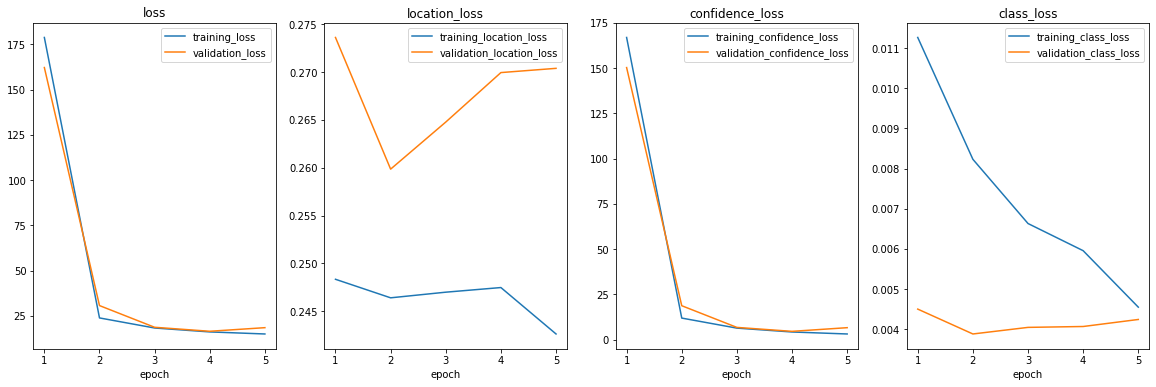

In [ ]:
path= '/content/newDatalog/plots_models/'
!rm -r {path}
!mkdir {path}
try:
  v=max([int(p.split('/')[-1]) for p in glob(f'{path}*')])+1
  print("model version:", v)
except:
  v=0
  print("Error: empty directory, model version:", v)
!mkdir {path}{v}
plot_training_statistics(history.history, f'{path}{v}/')

In [ ]:
from tensorflow.keras.optimizers import *
from tensorflow.keras.metrics import *
import copy
# continuous_hist=copy.deepcopy(history.history)


# for i in range(len(model.layers)):
#             model.layers[i].trainable = True
# print('Unfreeze all of the layers.')


RMSprop=RMSprop(learning_rate=0.0015,rho=0.9,momentum=0.97,epsilon=1e-08,decay=0.0,centered=False,name="RMSprop")
ada=Adadelta(learning_rate=0.0001, rho=0.95 , decay=0.0, epsilon=1e-08, name="Adadelta")
sgd = SGD(learning_rate=0.0001, decay=1e-4, momentum=0.97, nesterov=True) #learning_rate=0.01  decay=1e-4
opt=Adam(learning_rate=0.0001, )#beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0) #0.0001

model.compile(optimizer=opt, loss={'yolo_loss': lambda y_true, y_pred: y_pred})#,metrics=['acc'])#metrics=[Recall()]) #Accuracy(),Recall(),Precision()

In [ ]:
import copy
# continuous_hist=copy.deepcopy(history.history)

batch_size =batch_size
history=model.fit(data_generator(ens[len(ens)//10:],batch_size, input_shape, anchors, num_classes, size, 'Train_Set/'),
                validation_data= data_generator(ens[:len(ens)//10], batch_size, input_shape, anchors, num_classes, size, 'Train_Set/'),
                steps_per_epoch=len(ens)//10*9//batch_size,
                validation_steps=len(ens)//10//batch_size,
                initial_epoch=0, 
                epochs=25,    
                shuffle=False,  
                callbacks=[ logging,reduce_lr])

Epoch 1/25
 635/1924 [========>.....................] - ETA: 22:35 - loss: 26.3705 - location_loss: 0.0666 - confidence_loss: 14.7263 - class_loss: 0.0018

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in true_divide


1924/1924 [==============================] - 2316s 1s/step - loss: 16.5299 - location_loss: 0.0605 - confidence_loss: 5.1732 - class_loss: 0.0015 - val_loss: 11.0484 - val_location_loss: 0.0642 - val_confidence_loss: 0.2384 - val_class_loss: 0.0011 - lr: 1.0000e-04
Epoch 2/25
1924/1924 [==============================] - 2275s 1s/step - loss: 10.0612 - location_loss: 0.0589 - confidence_loss: 0.1621 - class_loss: 0.0010 - val_loss: 9.4131 - val_location_loss: 0.0644 - val_confidence_loss: 0.5979 - val_class_loss: 0.0011 - lr: 1.0000e-04
Epoch 3/25
1924/1924 [==============================] - 2230s 1s/step - loss: 7.5166 - location_loss: 0.0589 - confidence_loss: 0.0651 - class_loss: 0.0010 - val_loss: 6.4884 - val_location_loss: 0.0637 - val_confidence_loss: 0.4409 - val_class_loss: 0.0010 - lr: 1.0000e-04
Epoch 4/25
1924/1924 [==============================] - 2237s 1s/step - loss: 4.7274 - location_loss: 0.0589 - confidence_loss: 0.0455 - class_loss: 9.6799e-04 - val_loss: 3.5717 - va

In [ ]:
for key in continuous_hist.keys():
  for element in history.history[key]:
    continuous_hist[key].append(element)

In [ ]:
path= '/content/newDatalog/plots_models/'
!rm -r {path}
!mkdir {path}
try:
  v=max([int(p.split('/')[-1]) for p in glob(f'{path}*')])+1
  print("model version:", v)
except:
  v=0
  print("Error: empty directory, model version:", v)
!mkdir {path}{v}

plot_training_statistics(history.history, f'{path}{v}/')

In [ ]:
model.save('/content/drive/My Drive/Detection_models/masse_cal_v9.h5')
model.save_weights(log_dir + 'trained_weights_final.h5')
# !zip -r '/content/drive/MyDrive/Detection_models/TensorBoard/masse_cal_v7.zip' '/content/newDatalog'

# !zip -r '/content/drive/MyDrive/INBreast_Dataset/Train_dicom' '/content/Train_Set/Images'



Error: empty directory, model version: 0


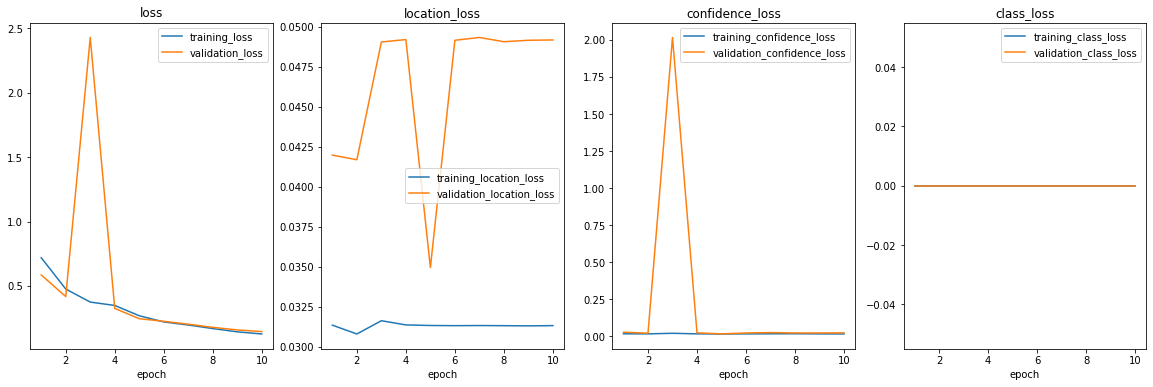

In [ ]:
path= '/content/newDatalog/plots_models/'
!rm -r {path}
!mkdir {path}
try:
  v=max([int(p.split('/')[-1]) for p in glob(f'{path}*')])+1
  print("model version:", v)
except:
  v=0
  print("Error: empty directory, model version:", v)
!mkdir {path}{v}

plot_training_statistics(history.history, f'{path}{v}/')

**serialize model to JSON**

In [ ]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

In [ ]:
# Precision = (True Positive)/(True Positive + False Positive)
# Recall = (True Positive)/(True Positive + False Negative)
# F1 score = (Precision × Recall)/[(Precision + Recall)/2]

In [ ]:
# https://github.com/Adamdad/Object-Detection-Metrics/blob/master/pascalvoc.py EVALUATION
#https://github.com/ashish-roopan/mAP  

##**Fine-tuning**

**Unfreeze and continue training** & **Compile** the model with my **custom loss function**

> Stochastic Gradient Descent SGD

1.  Frequent updates of model parameter
2.  Requires less Memory.
Allows the use of large data sets as it has to update only one example at a time.


**momentum** is used to penalize large weight changes between iterations.

 penalize large value for weights with  **decay** controls this penalty term. 

In [ ]:
from tensorflow.keras.optimizers import *
for i in range(len(model.layers)):
            model.layers[i].trainable = True
print('Unfreeze all of the layers.')

RMSprop=RMSprop(learning_rate=0.0001,rho=0.9,momentum=0.0,epsilon=1e-07,centered=False,name="RMSprop")
ada=Adadelta(learning_rate=0.001, rho=0.95, epsilon=1e-07, name="Adadelta")
sgd = SGD(learning_rate=0.0001, decay=1e-4, momentum=0.97, nesterov=True) #learning_rate=0.01  decay=1e-4
opt=Adam(learning_rate=1.0000e-04) #0.0001

model.compile(optimizer=RMSprop, loss={'yolo_loss': lambda y_true, y_pred: y_pred},) 

Unfreeze all of the layers.


**Begin the fine-tuning**


> batch size les then first trinig because that more GPU memory is required after unfreezing the body



In [ ]:
batch_size =16
history=model.fit(data_generator(ens[len(ens)//10:],batch_size, input_shape, anchors, num_classes, size, 'GenDataset/'),
                validation_data= data_generator(ens[:len(ens)//10], batch_size, input_shape, anchors, num_classes, size, 'GenDataset/'),
                steps_per_epoch=len(ens)//10*9//batch_size,
                validation_steps=len(ens)//10//batch_size,
                initial_epoch=5,
                epochs=10,
                shuffle=False,  
                callbacks=[ logging,reduce_lr]) 

Epoch 6/10
155/155 [==============================] - 796s 5s/step - loss: 0.3989 - location_loss: 0.0165 - confidence_loss: 0.0687 - class_loss: 0.0023 - val_loss: 0.3009 - val_location_loss: 0.0077 - val_confidence_loss: 0.0044 - val_class_loss: 0.0010 - lr: 1.0000e-04
Epoch 7/10
155/155 [==============================] - 750s 5s/step - loss: 0.3411 - location_loss: 0.0166 - confidence_loss: 0.0704 - class_loss: 0.0012 - val_loss: 0.2473 - val_location_loss: 0.0077 - val_confidence_loss: 0.0028 - val_class_loss: 7.4111e-04 - lr: 1.0000e-04
Epoch 8/10
155/155 [==============================] - 765s 5s/step - loss: 0.2385 - location_loss: 0.0162 - confidence_loss: 0.0054 - class_loss: 8.7051e-04 - val_loss: 0.2064 - val_location_loss: 0.0077 - val_confidence_loss: 0.0027 - val_class_loss: 5.5117e-04 - lr: 1.0000e-04
Epoch 9/10
155/155 [==============================] - 753s 5s/step - loss: 0.7836 - location_loss: 0.0159 - confidence_loss: 0.5746 - class_loss: 6.9033e-04 - val_loss: 0.1

rm: cannot remove '/content/newDatalog/plots_models/': No such file or directory
Error: empty directory, model version: 0


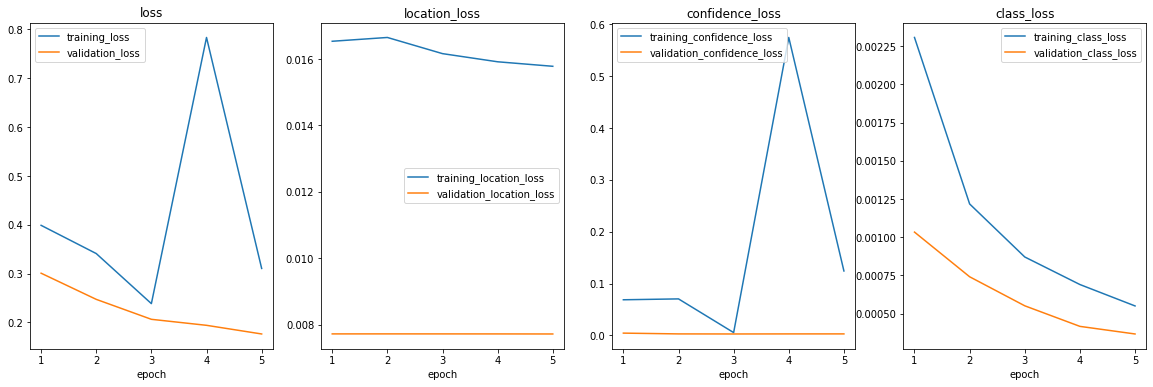

In [ ]:
path= '/content/newDatalog/plots_models/'
!rm -r {path}
!mkdir {path}
try:
  v=max([int(p.split('/')[-1]) for p in glob(f'{path}*')])+1
  print("model version:", v)
except:
  v=0
  print("Error: empty directory, model version:", v)
!mkdir {path}{v}

plot_training_statistics(history.history, f'{path}{v}/')

In [ ]:
model.save('/content/drive/My Drive/Detection_models/best_yolov3.h5')

**Plot loss resalts**
after fin_tuning of My model

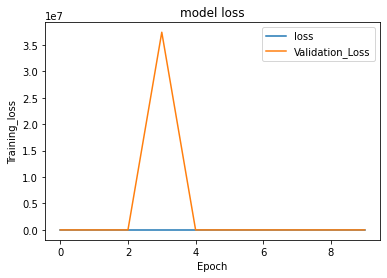

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("model loss")
plt.ylabel("Training_loss")
plt.xlabel("Epoch")
plt.legend(["loss","Validation_Loss"])
plt.show()

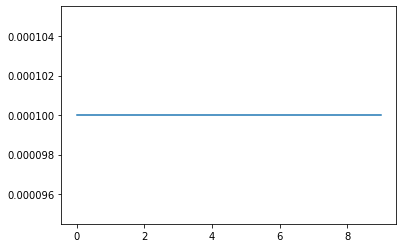

In [ ]:
plt.plot(history.history['lr'])

##**Tensorboard vusialisation**

In [ ]:
!unzip '/content/drive/MyDrive/Detection_models/TensorBoard/Best_log.zip' -r '01'
!unzip '/content/drive/MyDrive/Detection_models/TensorBoard/best_log2.zip' -r '02'
!unzip '/content/drive/MyDrive/Detection_models/TensorBoard/newDatalogv1.zip' -r '03'
!unzip '/content/drive/MyDrive/Detection_models/TensorBoard/newDatalogv2.zip' -r '04'

In [ ]:
!rm -r '/content/newDatalog/plots_models'

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir='/content/newDatalog/train/'